# Aprendizaje Semi-Supervisado con K-Means y Regresión Logística para Clasificación de Imágenes

Este cuaderno demuestra un enfoque de aprendizaje semi-supervisado para la clasificación de imágenes utilizando K-Means para el agrupamiento y Regresión Logística para la clasificación.

## Preparación del Entorno

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from PIL import Image
import matplotlib.pyplot as plt

train_images_dir = '/Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images'
test_images_dir = '/Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/test_images'

#test imagenes = 8000

#train imagenes = 5000

#sin etiquetas = 10000

## Visualización de Imágenes de Ejemplo

Mostramos algunas imágenes del conjunto de entrenamiento y prueba para tener una idea de los datos.


In [ ]:
def load_images_unlabeled(folder_path, image_size=(96, 96)):
    X = []
    for filename in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        if not os.path.isfile(img_path):
            continue
        try:
            img = Image.open(img_path).convert('RGB').resize(image_size)
            X.append(np.array(img))
        except Exception as e:
            print(f"Error al cargar imagen {img_path}: {e}")

    return np.array(X)

X_train = load_images_unlabeled(train_images_dir)
X_test = load_images_unlabeled(test_images_dir)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Error al cargar imagen /Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images/train_image_png_1.png: cannot identify image file '/Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images/train_image_png_1.png'
Error al cargar imagen /Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images/train_image_png_1038.png: cannot identify image file '/Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images/train_image_png_1038.png'
Error al cargar imagen /Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images/train_image_png_1041.png: cannot identify image file '/Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images/train_image_png_1041.png'
Error al cargar imagen /Users/adamcho/Documents/Pycharm/Aprendizaje N supervisado/stl10/versions/3/train_images/train_image_png_1046.png: cannot identify image fil

KeyboardInterrupt: 

## Visualización de Imágenes de Ejemplo

Mostramos algunas imágenes del conjunto de entrenamiento y prueba para tener una idea de los datos.


In [ ]:
# Aplana las imágenes
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Aplica K-Means
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train_flat)

# Encuentra los índices de las imágenes más cercanas a cada centroide
idxs = np.argmin(X_digits_dist, axis=0)

# Selecciona las imágenes representativas (sin etiquetas)
X_representative_images = X_train[idxs]

In [ ]:
print(X_representative_images.shape)

(10, 96, 96, 3)


## Selección de Imágenes Representativas por Cluster

Para cada cluster, seleccionamos algunas imágenes que están cerca del centroide. Estas imágenes nos ayudan a entender mejor el contenido de cada cluster.


In [ ]:
# Selecciona las 5 imágenes más cercanas a cada centroide
imagenes_por_cluster = 5
selected_idxs = []

for i in range(k):
    # Índices ordenados por distancia al centroide i
    idxs_cluster_i = np.argsort(X_digits_dist[:, i])[:imagenes_por_cluster]
    selected_idxs.extend(idxs_cluster_i)

X_representative_images = X_train[selected_idxs]
print(f"Total de imágenes seleccionadas: {len(X_representative_images)}")


Total de imágenes seleccionadas: 50


## Visualización de Imágenes Representativas

Mostramos las imágenes representativas para cada cluster.

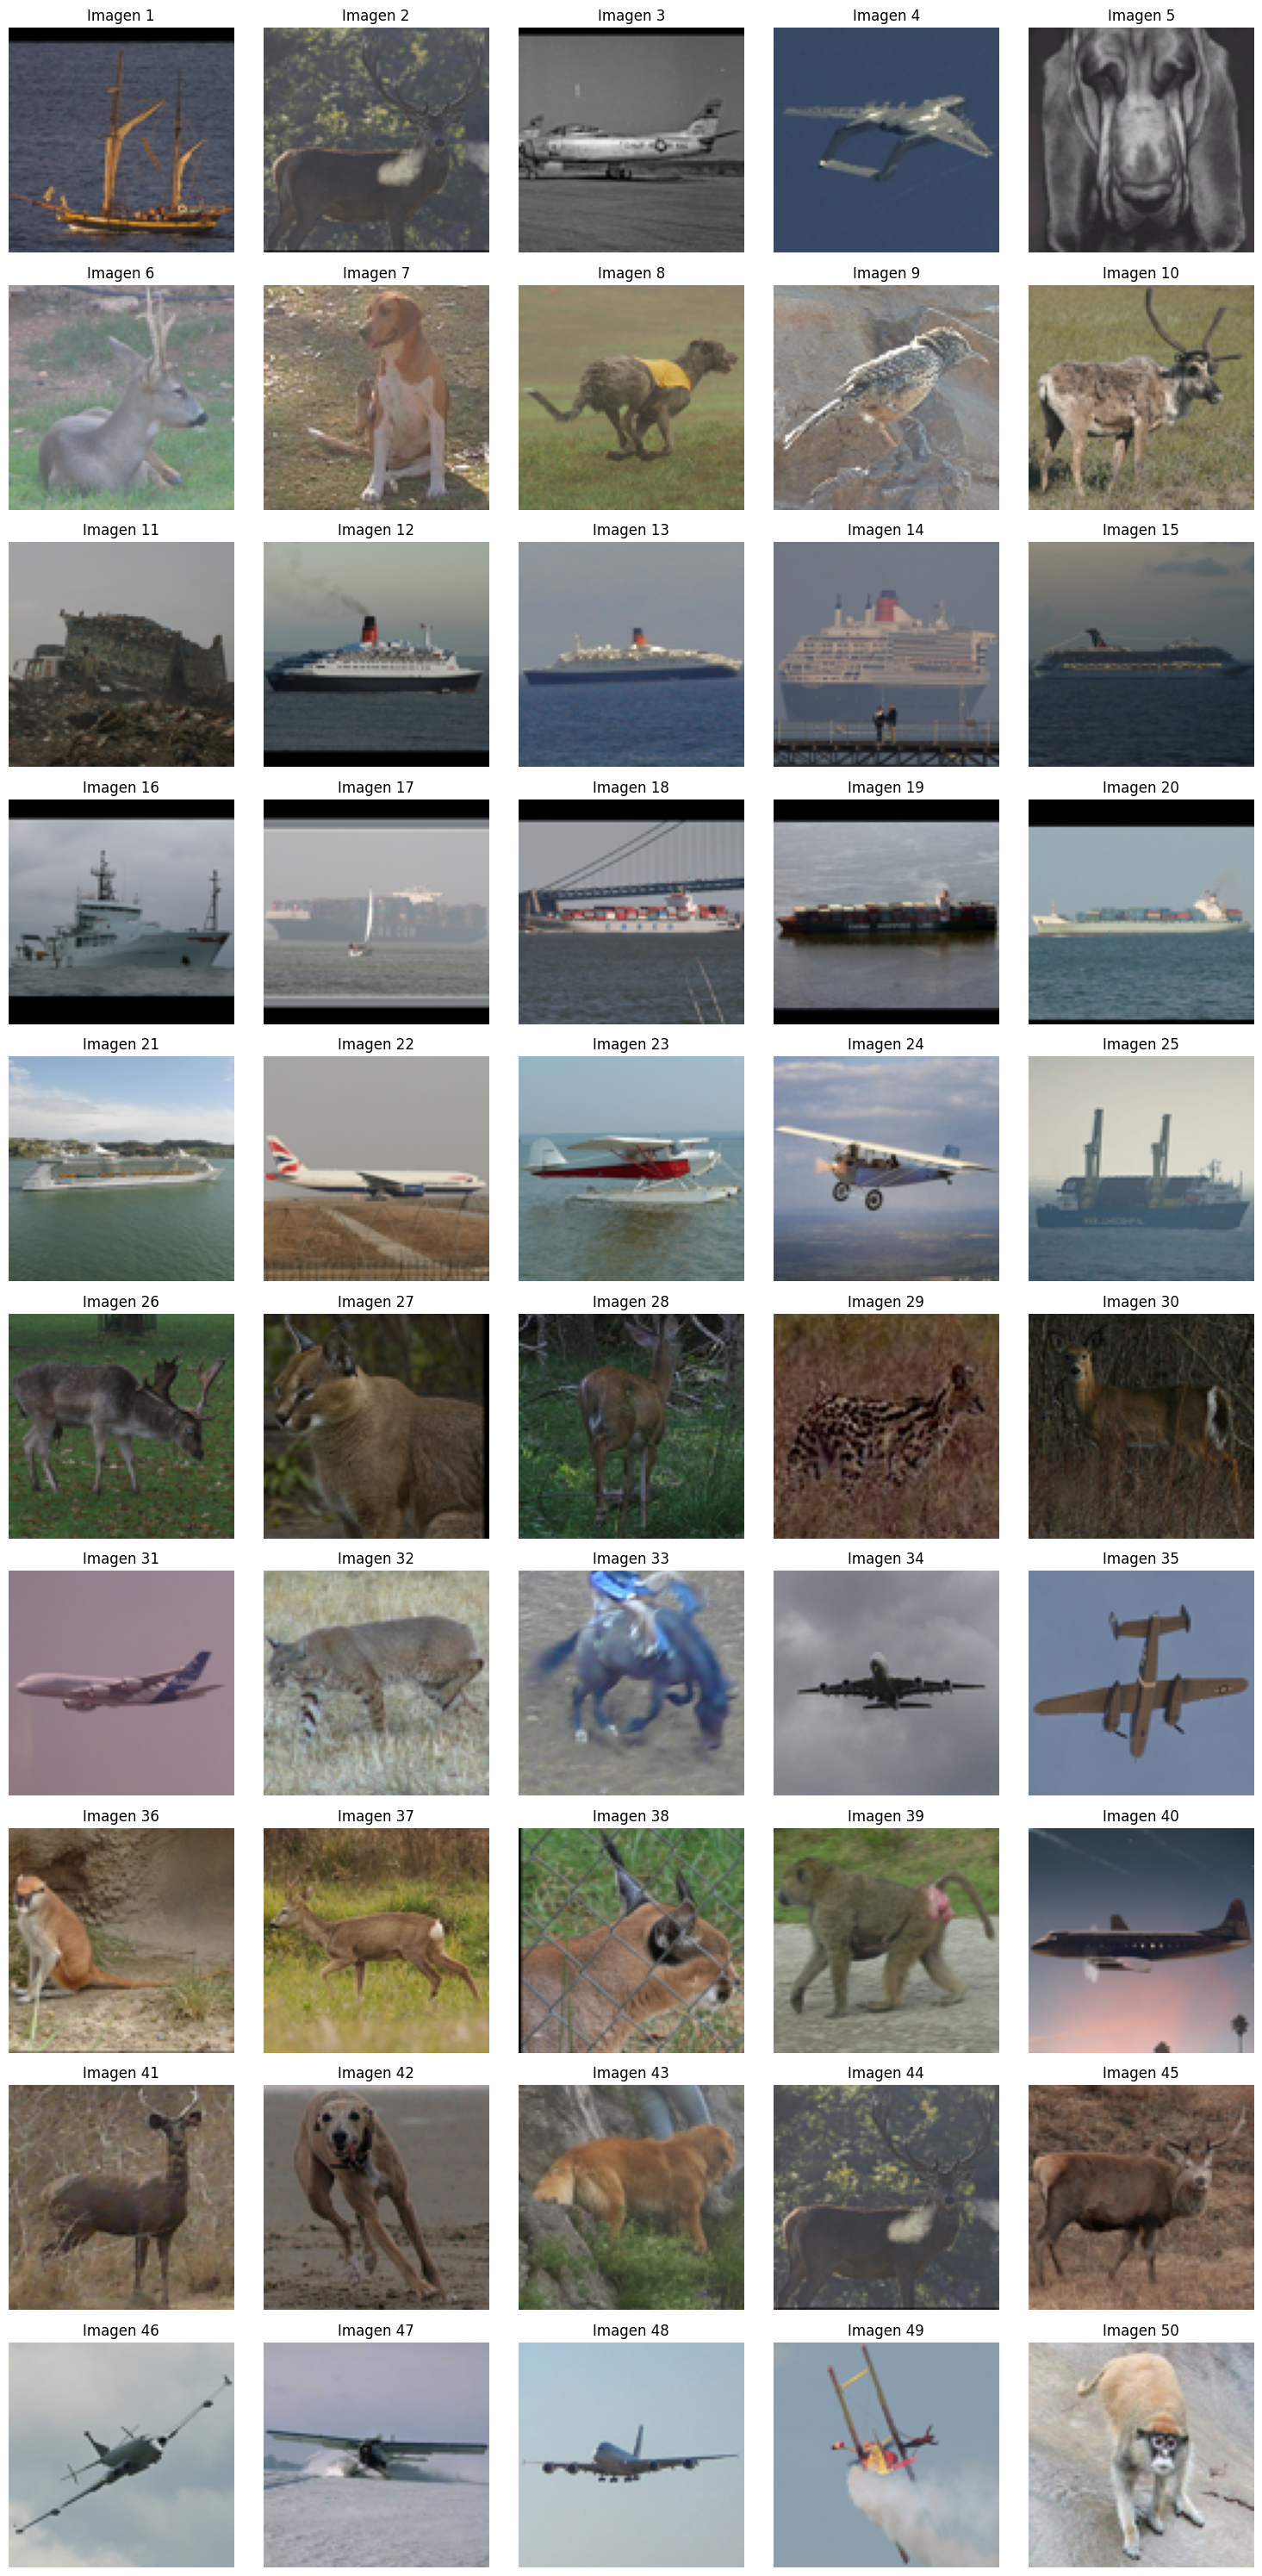

Observa las imágenes, luego cierra la ventana para continuar...


In [ ]:
import time

def mostrar_imagenes_en_grid(interactivas, imagenes_por_fila=5):
    total = len(interactivas)
    filas = (total + imagenes_por_fila - 1) // imagenes_por_fila

    fig, axs = plt.subplots(filas, imagenes_por_fila, figsize=(15, 3 * filas))
    axs = axs.flatten()

    for i, img in enumerate(interactivas):
        axs[i].imshow(img.astype(np.uint8))
        axs[i].set_title(f"Imagen {i+1}")
        axs[i].axis('off')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show(block=False)

    print("Observa las imágenes, luego cierra la ventana para continuar...")
    while plt.fignum_exists(fig.number):
        time.sleep(0.1)
mostrar_imagenes_en_grid(X_representative_images)


## Etiquetado de Clusters

Esta función permite asignar etiquetas a los clusters basándose en la inspección visual de las imágenes representativas.


In [ ]:
def pedir_etiquetas_manual(total):
    etiquetas_input = input(f"Introduce {total} etiquetas separadas por comas en el mismo orden mostrado:\n> ").strip()
    etiquetas = [et.strip() for et in etiquetas_input.split(",")]

    if len(etiquetas) != total:
        print(f"\n❌ Error: Se esperaban {total} etiquetas, pero se recibieron {len(etiquetas)}.")
        return None

    return etiquetas
# Luego solicita etiquetas
etiquetas = pedir_etiquetas_manual(len(X_representative_images))

## Entrenamiento de un Modelo de Clasificación

Utilizamos las imágenes representativas y las etiquetas asignadas para entrenar un modelo de clasificación. En este caso, utilizamos Regresión Logística con la estrategia One-vs-Rest.

In [ ]:
etiquetas = mostrar_clusters_con_etiquetas(X_representative_images)

if etiquetas:
    y_representative_images = np.array(etiquetas)
    X_flat = X_representative_images.reshape(X_representative_images.shape[0], -1)

    # Entrenar modelo con OneVsRest
    from sklearn.linear_model import LogisticRegression
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.model_selection import cross_val_score

    log_reg2 = OneVsRestClassifier(LogisticRegression(solver="lbfgs", max_iter=5000, random_state=42))

    cross_val_scores = cross_val_score(log_reg2, X_flat, y_representative_images, cv=5)
    print(f"Scores de validación cruzada: {cross_val_scores}")
    print(f"Precisión promedio: {cross_val_scores.mean()}")
